In [1]:
import os
import sys
import json
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_path)
from src.common.models import BPMNModel, ProcessModel, ActivityBreakdown, ValueAddingAnalysis
from src.bpmn_generation import BPMNGenerator
from src.activity_breakdown import ActivityBreakdownGPT
from src.value_adding_analysis import ValueClassificationComponentsGPT, PromptComponents


def perform_activity_breakdown(activity, bpmn_text, verbose=True) -> ActivityBreakdown:
    """Perform activity breakdown."""
    bpmn_model = BPMNModel.from_str(activity, bpmn_text)
    activity_decomposer = ActivityBreakdownGPT(prompt_components=None)
    activity_breakdown_response = activity_decomposer.bpmn_activity_breakdown(bpmn_model.model)
    model_activity_breakdown = ActivityBreakdown.from_dict(activity, activity_breakdown_response)
    
    if verbose:
        print_activity_breakdown_results(model_activity_breakdown)
    
    return model_activity_breakdown


def print_activity_breakdown_results(model_activity_breakdown):
    """Print activity breakdown results."""
    print("+"*50)
    print("\nActivity Breakdown:")
    print(model_activity_breakdown)
    print("+"*50)

def open_file(file_path, file_type=".txt"):
    """Open file."""
    if file_type == ".txt":
        with open(file_path, "r") as f:
            file_content = f.read()
    elif file_type == ".json":
        with open(file_path, "r") as f:
            file_content = json.load(f)
    else:
        raise ValueError(f"File type {file_type} not supported.")
    return file_content


In [2]:
ROOT_DIR = r"C:\Projects\Research\SWEEP\SWEEP"
SECTOR = "banking"
ACTIVITY = "credit_check"
ground_truth_path = os.path.join(ROOT_DIR, "data", SECTOR, ACTIVITY, f"{ACTIVITY}_activity_breakdown.json")
model_path = os.path.join(ROOT_DIR, "data", SECTOR, ACTIVITY, f"{ACTIVITY}_model.txt")

model_text = open_file(model_path)
ground_truth_dict = open_file(ground_truth_path, file_type=".json")

activity_breakdown = perform_activity_breakdown(ACTIVITY, model_text)

++++++++++++++++++++++++++++++++++++++++++++++++++

Activity Breakdown:
Activity Breakdown: credit_check
Activity: Check completeness
Step 1: Review application form

Step 2: Verify all required fields are filled

Step 3: Check for any missing or incomplete information

Activity: Check credit history
Step 1: Retrieve credit history records

Step 2: Analyze credit score

Step 3: Assess creditworthiness based on history

Activity: Check income sources
Step 1: Collect income documents

Step 2: Verify income sources

Step 3: Calculate total income

Activity: Assess application
Step 1: Evaluate credit and income information

Step 2: Analyze debt-to-income ratio

Step 3: Consider additional factors (e.g., employment history)

Activity: Make credit offer
Step 1: Determine credit terms and conditions

Step 2: Prepare credit offer document

Step 3: Communicate credit offer to applicant

Activity: Notify rejection
Step 1: Prepare rejection notification

Step 2: Communicate rejection to applicant

In [ ]:
from src.activity_breakdown import ActivityBreakdownComparatorGPT, ActivityBreakdownEvaluation
from src.common.models import ActivityBreakdownComparison

activity_breakdown_evaluation = ActivityBreakdownEvaluation()

comparison_data = activity_breakdown_evaluation.compare_activity_breakdowns(activity_breakdown, ground_truth_dict)

activity_breakdown_evaluation.evaluate_comparisons(comparison_data)


In [3]:

activity_breakdown_comparison = ActivityBreakdownComparatorGPT()

comparison_data = []
for i, activity in enumerate(activity_breakdown.to_dict()):
    print(f"Comparing activity {i+1}...")
    comparison_object = activity_breakdown_comparison.compare_activity_breakdown(ground_truth_dict[i], activity)
    comparison_data.append(comparison_object)
    

Comparing activity 1...
Comparing activity 2...
Comparing activity 3...
Comparing activity 4...
Comparing activity 5...
Comparing activity 6...


In [4]:
comparison_objects = [ActivityBreakdownComparison.from_dict(comparison) for comparison in comparison_data]
comparison_objects

[ActivityBreakdownComparison(activity_name='Check completeness', step_mappings=[StepMapping(ground_truth_steps=[SubStep(step_number=1, description='Review all submitted application documents', classification=None, reasoning=None)], response_steps=[SubStep(step_number=1, description='Review application form', classification=None, reasoning=None)], match_type='Semantic Match', confidence=80, explanation='Ground truth step 1 corresponds to response step 1. The response step is a more specific version of the ground truth step.'), StepMapping(ground_truth_steps=[SubStep(step_number=2, description='Verify all required fields are filled', classification=None, reasoning=None)], response_steps=[SubStep(step_number=2, description='Verify all required fields are filled', classification=None, reasoning=None)], match_type='Exact Match', confidence=100, explanation='Ground truth step 2 and response step 2 are identical in wording and meaning.'), StepMapping(ground_truth_steps=[SubStep(step_number=3,

In [5]:
comparison_dicts = [comparison_objects.to_dict() for comparison_objects in comparison_objects]
comparison_data = comparison_dicts

In [6]:
import json
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

total_activities = len(comparison_data)
# Assuming comparison_data is a list of comparison objects
def evaluate_comparisons(comparison_data):
    # Initialize accumulators for metrics
    match_type_counts = Counter()
    confidence_scores = []
    match_type_confidences = defaultdict(list)
    ground_truth_steps_total = 0
    response_steps_total = 0
    ground_truth_steps_matched = 0
    response_steps_matched = 0
    sequence_alignment_scores = []
    overall_similarity_scores = []

    # Collect data for qualitative analysis
    examples_by_match_type = defaultdict(list)
    unmatched_ground_truth_steps = []
    unmatched_response_steps = []
    granularity_issues = []

    for activity in comparison_data:
        activity_name = activity['activity_name']
        step_mappings = activity['step_mappings']
        unmatched_gt_steps = activity.get('unmatched_ground_truth_steps', [])
        unmatched_resp_steps = activity.get('unmatched_response_steps', [])
        overall_similarity_score = activity.get('overall_similarity_score', 0)

        # Update overall similarity scores
        overall_similarity_scores.append(overall_similarity_score)

        # Update total steps
        num_ground_truth_steps = sum(len(mapping['ground_truth_steps']) for mapping in step_mappings) + len(unmatched_gt_steps)
        num_response_steps = sum(len(mapping['response_steps']) for mapping in step_mappings) + len(unmatched_resp_steps)
        ground_truth_steps_total += num_ground_truth_steps
        response_steps_total += num_response_steps

        # Update matched steps
        matched_gt_steps = sum(len(mapping['ground_truth_steps']) for mapping in step_mappings)
        matched_resp_steps = sum(len(mapping['response_steps']) for mapping in step_mappings)
        ground_truth_steps_matched += matched_gt_steps
        response_steps_matched += matched_resp_steps

        # Update match type counts and confidences
        for mapping in step_mappings:
            match_type = mapping['match_type']
            confidence = mapping['confidence']
            match_type_counts[match_type] += 1
            confidence_scores.append(confidence)
            match_type_confidences[match_type].append(confidence)

            # Collect examples for qualitative analysis
            examples_by_match_type[match_type].append({
                'activity_name': activity_name,
                'ground_truth_steps': mapping['ground_truth_steps'],
                'response_steps': mapping['response_steps'],
                'confidence': confidence,
                'explanation': mapping['explanation']
            })

            # Check for granularity issues
            if len(mapping['ground_truth_steps']) != len(mapping['response_steps']):
                granularity_issues.append({
                    'activity_name': activity_name,
                    'mapping': mapping
                })

        # Collect unmatched steps for qualitative analysis
        for step in unmatched_gt_steps:
            unmatched_ground_truth_steps.append({
                'activity_name': activity_name,
                'step': step
            })

        for step in unmatched_resp_steps:
            unmatched_response_steps.append({
                'activity_name': activity_name,
                'step': step
            })

        # Sequence Alignment (Simple Measure)
        gt_step_numbers = [gt_step['step_number'] for mapping in step_mappings for gt_step in mapping['ground_truth_steps']]
        resp_step_numbers = [resp_step['step_number'] for mapping in step_mappings for resp_step in mapping['response_steps']]

        # Simple ratio of steps in correct order
        sequence_score = compute_sequence_alignment(gt_step_numbers, resp_step_numbers)
        sequence_alignment_scores.append(sequence_score)

    # Compute quantitative metrics
    metrics = {}

    # Match Type Distribution
    total_matches = sum(match_type_counts.values())
    metrics['match_type_distribution'] = {k: (v, v / total_matches * 100) for k, v in match_type_counts.items()}

    # Average Confidence Scores
    metrics['average_confidence'] = np.mean(confidence_scores)
    metrics['average_confidence_by_match_type'] = {k: np.mean(v) for k, v in match_type_confidences.items()}

    # Step Matching Rates
    metrics['ground_truth_coverage'] = ground_truth_steps_matched / ground_truth_steps_total * 100 if ground_truth_steps_total else 0
    metrics['response_coverage'] = response_steps_matched / response_steps_total * 100 if response_steps_total else 0

    # Sequence Alignment
    metrics['average_sequence_alignment'] = np.mean(sequence_alignment_scores)

    # Overall Similarity Score
    metrics['average_overall_similarity_score'] = np.mean(overall_similarity_scores)

    # Generate reports
    generate_reports(metrics, examples_by_match_type, unmatched_ground_truth_steps, unmatched_response_steps, granularity_issues)

def compute_sequence_alignment(gt_steps, resp_steps):
    # Simple sequence alignment score
    # Counts the number of steps in the correct relative order
    matches = 0
    for i in range(min(len(gt_steps), len(resp_steps))):
        if gt_steps[i] == resp_steps[i]:
            matches += 1
    return matches / max(len(gt_steps), len(resp_steps)) * 100 if max(len(gt_steps), len(resp_steps)) else 0

def generate_reports(metrics, examples_by_match_type, unmatched_gt_steps, unmatched_resp_steps, granularity_issues):
    # Print quantitative metrics
    print("Quantitative Metrics:")
    print("=====================")
    print(f"Total Activities Evaluated: {total_activities}")
    print(f"Average Overall Similarity Score: {metrics['average_overall_similarity_score']:.2f}%")
    print(f"Average Confidence Score: {metrics['average_confidence']:.2f}%")
    print(f"Average Sequence Alignment Score: {metrics['average_sequence_alignment']:.2f}%")
    print(f"Ground Truth Steps Coverage: {metrics['ground_truth_coverage']:.2f}%")
    print(f"Response Steps Coverage: {metrics['response_coverage']:.2f}%\n")

    print("Match Type Distribution:")
    for match_type, (count, percentage) in metrics['match_type_distribution'].items():
        avg_confidence = metrics['average_confidence_by_match_type'][match_type]
        print(f"- {match_type}: {count} matches ({percentage:.2f}%), Average Confidence: {avg_confidence:.2f}%")
    print("\n")

    # Generate charts
    plot_match_type_distribution(metrics['match_type_distribution'])
    plot_confidence_by_match_type(metrics['average_confidence_by_match_type'])

    # Qualitative Analysis
    print("Qualitative Analysis:")
    print("=====================\n")

    print("Examples of Matched Steps by Match Type:\n")
    for match_type, examples in examples_by_match_type.items():
        print(f"Match Type: {match_type}")
        for example in examples[:3]:  # Limit to first 3 examples
            print(f"Activity: {example['activity_name']}")
            print("Ground Truth Steps:")
            for step in example['ground_truth_steps']:
                print(f"  - [{step['step_number']}] {step['description']}")
            print("Response Steps:")
            for step in example['response_steps']:
                print(f"  - [{step['step_number']}] {step['description']}")
            print(f"Confidence: {example['confidence']}%")
            print(f"Explanation: {example['explanation']}\n")
        print("\n")

    print("Analysis of Unmatched Ground Truth Steps:")
    for item in unmatched_gt_steps[:5]:  # Limit to first 5
        print(f"Activity: {item['activity_name']}, Step: [{item['step']['step_number']}] {item['step']['description']}")
        print(f"Reason: {item['step'].get('reason', 'No reason provided')}\n")

    print("Analysis of Unmatched Response Steps:")
    for item in unmatched_resp_steps[:5]:  # Limit to first 5
        print(f"Activity: {item['activity_name']}, Step: [{item['step']['step_number']}] {item['step']['description']}")
        print(f"Reason: {item['step'].get('reason', 'No reason provided')}\n")

    print("Granularity Issues Identified:")
    for issue in granularity_issues[:5]:  # Limit to first 5
        mapping = issue['mapping']
        print(f"Activity: {issue['activity_name']}")
        print("Ground Truth Steps:")
        for step in mapping['ground_truth_steps']:
            print(f"  - [{step['step_number']}] {step['description']}")
        print("Response Steps:")
        for step in mapping['response_steps']:
            print(f"  - [{step['step_number']}] {step['description']}")
        print(f"Explanation: {mapping['explanation']}\n")

def plot_match_type_distribution(match_type_distribution):
    match_types = list(match_type_distribution.keys())
    counts = [match_type_distribution[mt][0] for mt in match_types]
    percentages = [match_type_distribution[mt][1] for mt in match_types]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=match_types, y=percentages)
    plt.title('Match Type Distribution')
    plt.xlabel('Match Type')
    plt.ylabel('Percentage (%)')
    plt.show()

def plot_confidence_by_match_type(average_confidence_by_match_type):
    match_types = list(average_confidence_by_match_type.keys())
    confidences = [average_confidence_by_match_type[mt] for mt in match_types]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=match_types, y=confidences)
    plt.title('Average Confidence Score by Match Type')
    plt.xlabel('Match Type')
    plt.ylabel('Average Confidence (%)')
    plt.show()
    
evaluate_comparisons(comparison_data)


Quantitative Metrics:
Total Activities Evaluated: 6
Average Overall Similarity Score: 59.08%
Average Confidence Score: 57.62%
Average Sequence Alignment Score: 72.50%
Ground Truth Steps Coverage: 84.00%
Response Steps Coverage: 94.12%

Match Type Distribution:
- Semantic Match: 9 matches (42.86%), Average Confidence: 77.78%
- Exact Match: 3 matches (14.29%), Average Confidence: 100.00%
- Partial Match: 3 matches (14.29%), Average Confidence: 70.00%
- No Match: 6 matches (28.57%), Average Confidence: 0.00%




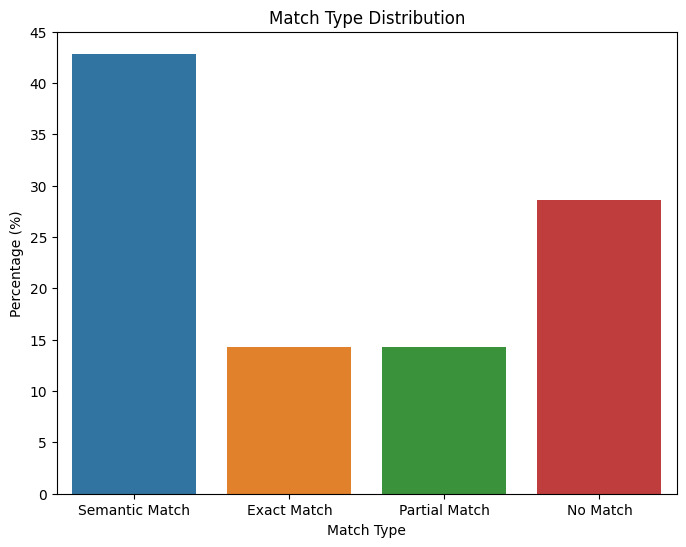

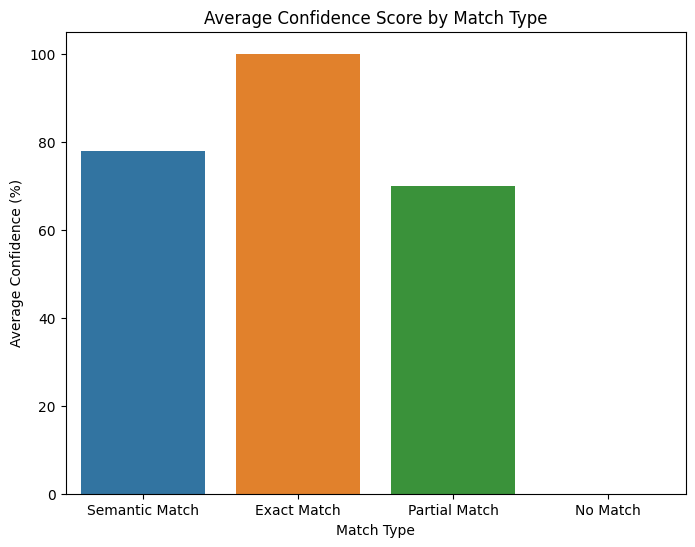

Qualitative Analysis:

Examples of Matched Steps by Match Type:

Match Type: Semantic Match
Activity: Check completeness
Ground Truth Steps:
  - [1] Review all submitted application documents
Response Steps:
  - [1] Review application form
Confidence: 80%
Explanation: Ground truth step 1 corresponds to response step 1. The response step is a more specific version of the ground truth step.

Activity: Check completeness
Ground Truth Steps:
  - [3] Ensure all necessary supporting documents are attached
Response Steps:
  - [3] Check for any missing or incomplete information
Confidence: 70%
Explanation: Ground truth step 3 corresponds to response step 3. The response step conveys the same meaning but is worded differently.

Activity: Check credit history
Ground Truth Steps:
  - [1] Request credit report from credit bureau
Response Steps:
  - [1] Retrieve credit history records
Confidence: 90%
Explanation: Ground truth step 1 corresponds to response step 1.



Match Type: Exact Match
Activit